# FILM JUNKY UNION. Categorizar reseñas de películas

## Contenido <a id='back'></a>

* [1. Descripción del proyecto](#intro) 
* [2. Exploración de datos](#exploration)
* [3. Análsis Exploratorio de Datos](#eda)
* [4. Procedimiento de evaluación](#evaluation)
* [5. Normalización](#normalization)
* [6. División entrenamiento / prueba](#model)
* [7. Mis reseñas](#reviews)
* [Conclusiones](#end)

## 1. Descripcipción del proyecto <a id='intro'></a>


Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

[Regresar a contenido](#back)

## 2. Exploración de datos <a id="exploration"></a>

## Inicialización

In [1]:
import math
import re
import nltk
import spacy
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics
import lightgbm as lgb
import torch
import transformers

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.translate.meteor_score import wordnet

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

### Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [8]:
df_reviews[df_reviews['votes'].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


En este caso podemos datos ausentes en las columnas 'average_rating' y 'votes', sin embargo , en este proyecto las clomunas de interés son 'review', 'pos' y 'ds_part', por lo que no afectará en nuestro análisis de textos y dejaremos estos datos ausentes.

In [9]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


En genral se puede observar que no contiene elementos que puedan perjudicar el análisis, se encontraron pocos datos ausentes y se puede observar que las columnas de años tienen un tipo de datos erroneo pero no se corrigieron estas incidencias en el DataFrame ya que no  intevienen en el objetivo de este proyecto.

[Regresar a contenido](#back)

## 3. EDA <a id="eda"></a>

Veamos el número de películas y reseñas a lo largo de los años.

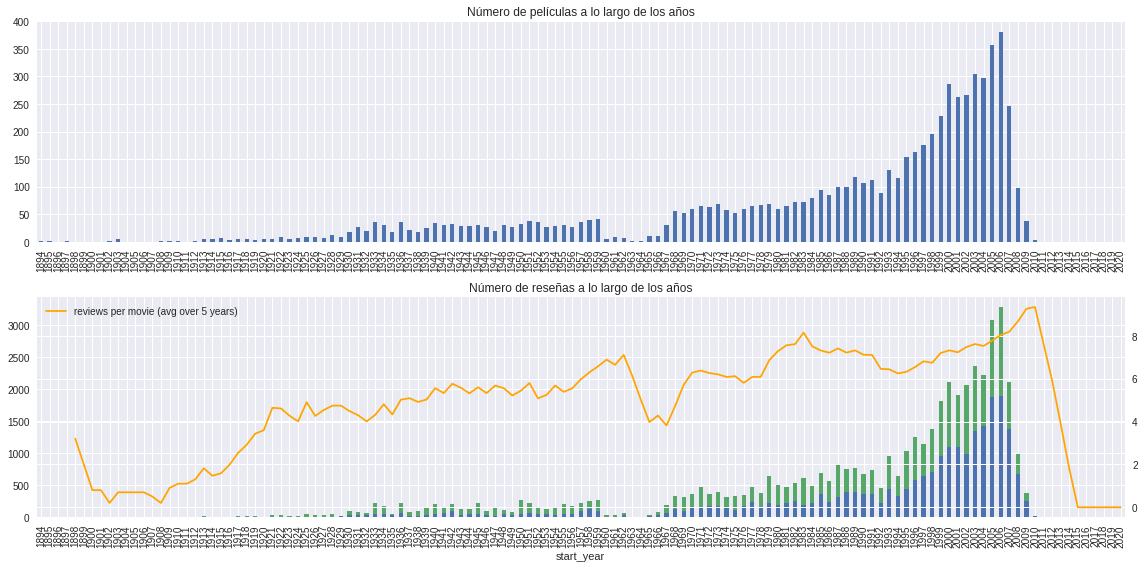

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

En los gráficos anteriores, se puede observar que en general, tiene un comportamiento ascendente, viendose un crecimiento más significativo a partir del año 1995, y teniendo un máximo de reseñas en el año 2007, pero a partir de este año comienza a disminuir mucho las reseñas.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

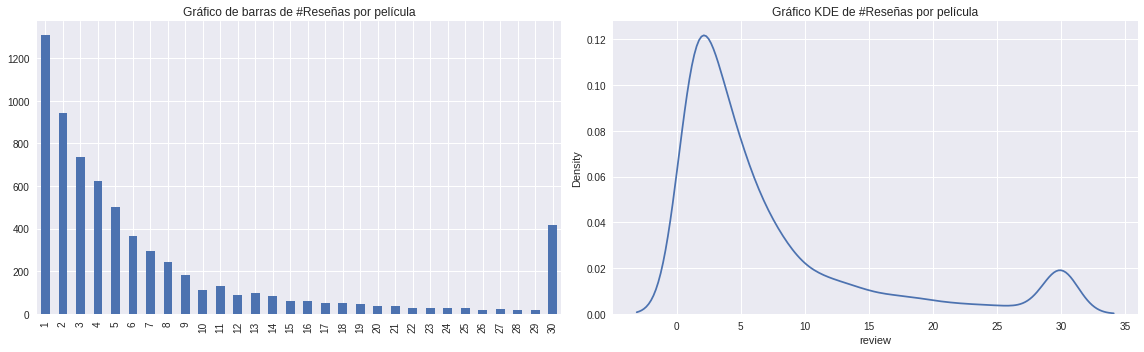

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

En las gráficas podemos observar el comportamiento de las reseñas por películas, tanto en un gráfico de barras como en un gráfico KDE, donde observamos en ambos gráficos un comportamiento semejante.

In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

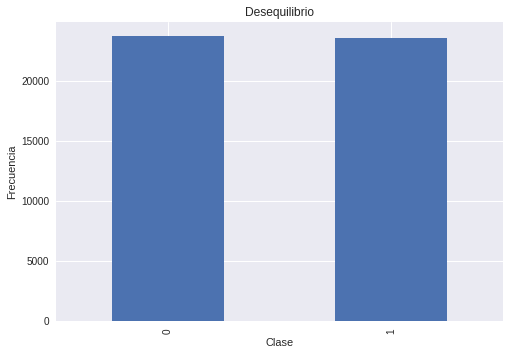

In [13]:
count_classes = pd.value_counts(df_reviews['pos'], sort = True)
count_classes.plot(kind = 'bar')
plt.title("Desequilibrio")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

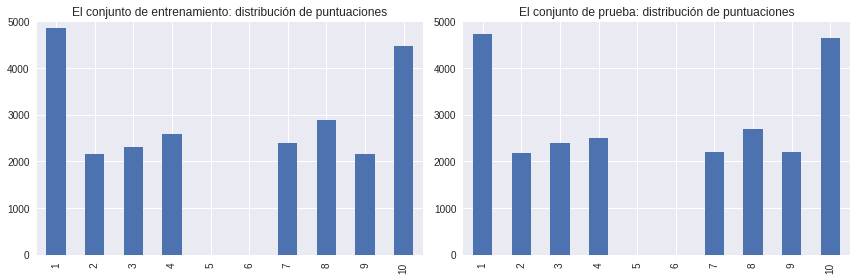

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Podemos observar que existe un equilibrio, por ejemplo, en el  análisis global, podemos sobservar que la cantidad de de seseñas positivas y negativas tienen un valor cercano entre sí, por lo que podemos determinar que hay un equilibrio en los datos, esto también lo podemos observar en los conjuntos de datos de entrenamiento y de prueba por separado, donde podemos observar un comportamiento similar en su distribución de puntuaciones. 

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


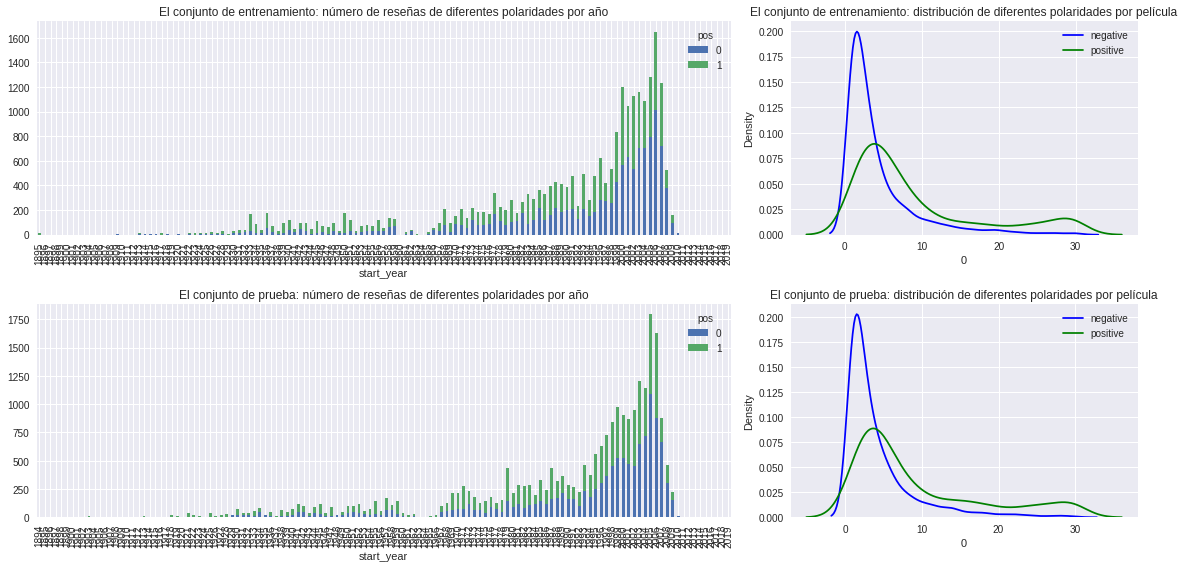

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

[Regresar a contenido](#back)

## 4. Procedimiento de evaluación <a id="evaluation"></a>

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [16]:

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

[Regresar a contenido](#back)

## 5. Normalización <a id="normalization"></a>

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [17]:
pattern = r"[^a-zA-Z ']"  
    
def clear_text(text):
    
    pattern = r"[^a-zA-Z']" 
    
    clean_text = re.sub(pattern, ' ', text)
    clean_text = " ".join(clean_text.lower().split())

    return clean_text 



In [18]:
%%time
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)
df_reviews['review_norm'].head()

CPU times: user 4.87 s, sys: 27.2 ms, total: 4.9 s
Wall time: 4.92 s


0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

In [20]:
def lemma_nltk(text):
   

    tokens =  word_tokenize(text)
        
    lemmatizer = WordNetLemmatizer() 
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
                  
    return " ".join(lemmas)

In [21]:
%%time
df_reviews['nltk_lemma'] = df_reviews['review_norm'].apply(lemma_nltk)
df_reviews['nltk_lemma']

CPU times: user 1min 58s, sys: 189 ms, total: 1min 58s
Wall time: 1min 58s


0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teen in singa...
4        i 'm totally agree with garryjohal from singap...
                               ...                        
47326    this is another of my favorite columbo it spor...
47327    talk about being boring i got this expecting a...
47328    i never thought i 'd say this about a biopic b...
47329    spirit and chaos is an artistic biopic of miya...
47330    i 'll make this brief this wa a joy to watch i...
Name: nltk_lemma, Length: 47331, dtype: object

In [22]:


nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemma_spacy(text):
    
    doc = nlp(text)
    lemma = [token.lemma_ for token in doc]
    
    return ' '.join(lemma)

In [23]:
%%time
df_reviews['spacy_lemma'] = df_reviews['review_norm'].apply(lemma_spacy)
df_reviews['spacy_lemma'].head()



CPU times: user 17min 37s, sys: 4.34 s, total: 17min 42s
Wall time: 17min 42s


0    the pakage imply that warren beatty and goldie...
1    how the hell do they get this make present its...
2    there be no real story the film seem more like...
3    um a serious film about troubled teen in singa...
4    I be totally agree with garryjohal from singap...
Name: spacy_lemma, dtype: object

[Regresar a contenido](#back)

## 6. División entrenamiento / prueba <a id="model"></a>

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [24]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 20)
(23535, 20)


In [25]:
# Se definen las palabra vacías 

stop_words = set(stopwords.words('english')) # Definición de palabras vacías
#count_tf_idf = TfidfVectorizer(stop_words = stop_words) #Vectorización

In [26]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm,nltk_lemma,spacy_lemma
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...,the pakage implies that warren beatty and gold...,the pakage imply that warren beatty and goldie...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...,how the hell did they get this made presenting...,how the hell do they get this make present its...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,there is no real story the film seems more lik...,there is no real story the film seems more lik...,there be no real story the film seem more like...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um a serious film about troubled teens in sing...,um a serious film about troubled teen in singa...,um a serious film about troubled teen in singa...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,i'm totally agree with garryjohal from singapo...,i 'm totally agree with garryjohal from singap...,I be totally agree with garryjohal from singap...


In [27]:
#Ntkl lemma

count_tf_idf_ntlk = TfidfVectorizer(stop_words = stop_words)
features_train_ntkl = count_tf_idf_ntlk.fit_transform(df_reviews_train['nltk_lemma']) #Features de entrenamiento de ntkl
features_test_ntkl = count_tf_idf_ntlk.transform(df_reviews_test['nltk_lemma']) #Target de entrenamiento de ntk

#spacy lemma

count_tf_idf_spacy = TfidfVectorizer(stop_words = stop_words)
features_train_spacy = count_tf_idf_spacy.fit_transform(df_reviews_train['spacy_lemma']) #Features de entrenamiento de spacy
features_test_spacy = count_tf_idf_spacy.transform(df_reviews_test['spacy_lemma']) #Target de entrenamiento de spacy



In [28]:
features_train_ntkl

<23796x64299 sparse matrix of type '<class 'numpy.float64'>'
	with 2319940 stored elements in Compressed Sparse Row format>

## Trabajar con modelos

### Modelo 0 - Constante

In [29]:
#Creación y entrenamiento del modelo

dummy_model = DummyClassifier(strategy = 'constant', constant = 1)
dummy_model.fit(features_train_ntkl,train_target)

DummyClassifier(constant=1, strategy='constant')

           train  test
Exactitud    NaN   NaN
F1          0.67  0.67
APS         0.50  0.50
ROC AUC     0.50  0.50


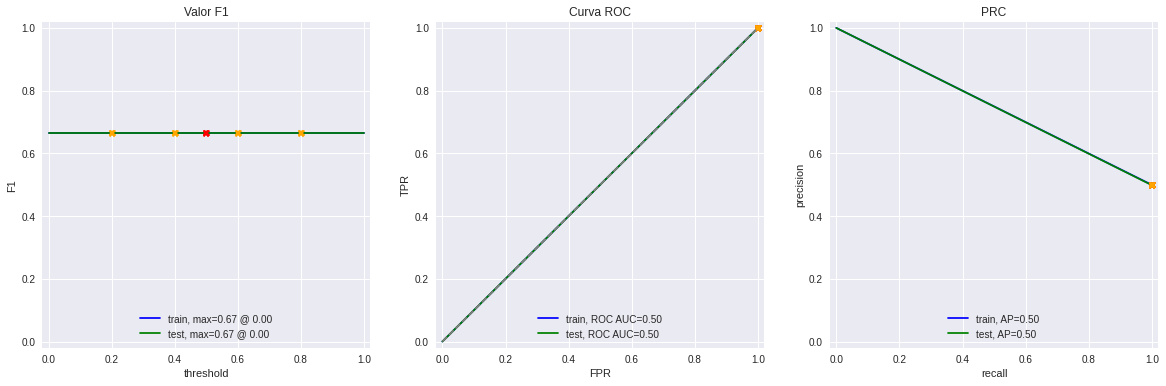

In [30]:
#Evaluación del modelo
evaluate_model(dummy_model, features_train_ntkl, train_target, features_test_ntkl, test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [31]:
#Creación del modelo

model_1 = LogisticRegression()

In [32]:
#Entrenamiento

model_1.fit(features_train_ntkl,train_target)


LogisticRegression()

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


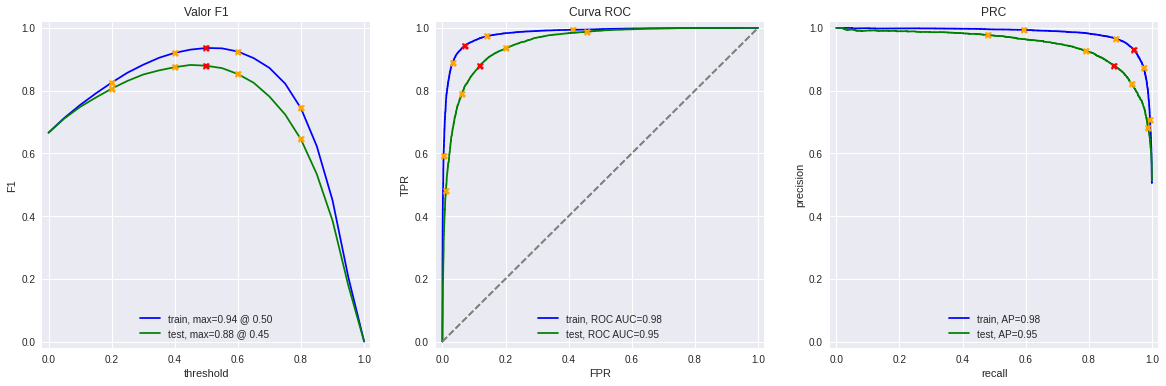

In [33]:
#Evaluación del modelo

evaluate_model(model_1, features_train_ntkl, train_target, features_test_ntkl, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [34]:
#Creación del modelo

model_3 = LogisticRegression()

In [35]:
#Entrenamiento

model_3.fit(features_train_spacy,train_target)


LogisticRegression()

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


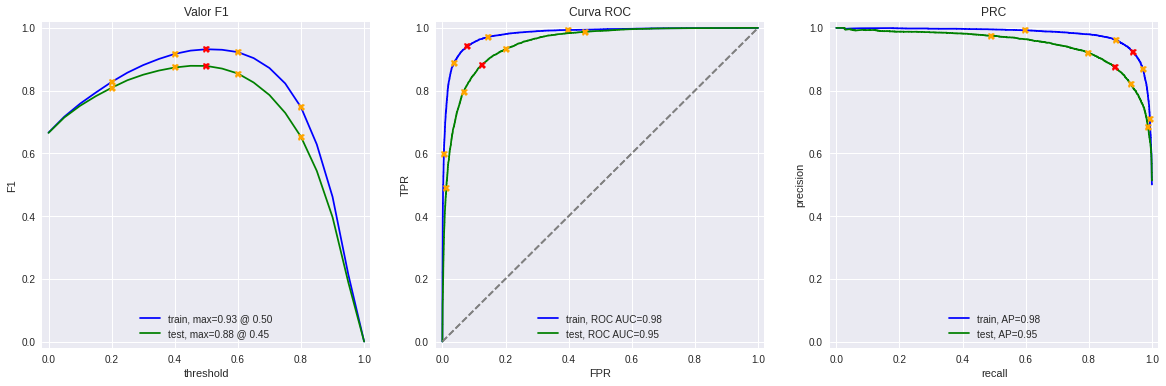

In [36]:
#Evaluación del modelo

evaluate_model(model_3, features_train_spacy, train_target, features_test_spacy, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [37]:
#Creación del modelo

#model_4 = lgb.LGBMRegressor()

param_grid = {'learning_rate': [.1,0.15],
              'max_depth': [10,15],
              'n_estimators': [100,150],
              'n_jobs': [-1],
              'random_state' : [12345],
              'verbose': [-1]
             }

model_4 = GridSearchCV(LGBMClassifier(), 
                        param_grid, 
                        scoring ='f1',  
                        cv=4
                       )

model_4.fit(features_train_spacy,train_target)
model_4 = model_4.best_estimator_

In [38]:
#Entrenamiento

#model_4.fit(features_train_spacy,train_target)


           train  test
Exactitud    NaN   NaN
F1          0.96  0.86
APS         0.99  0.94
ROC AUC     0.99  0.94


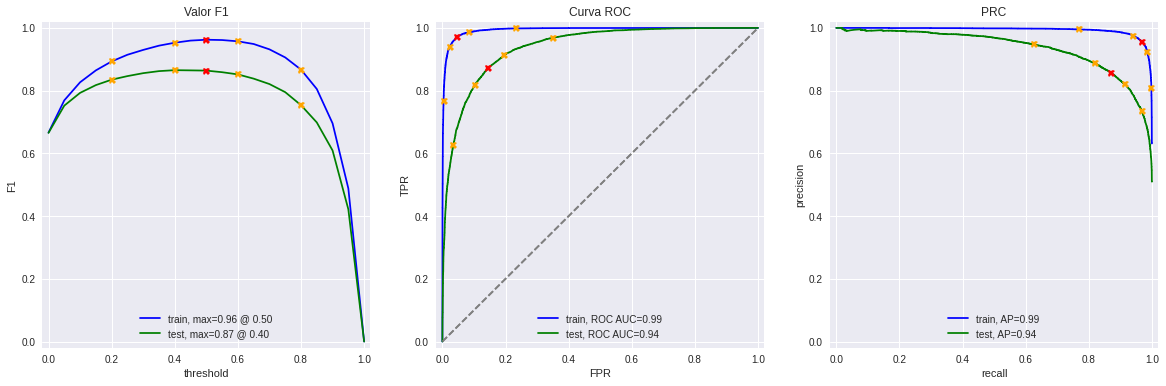

In [39]:
#Evaluación del modelo

evaluate_model(model_4, features_train_spacy, train_target, features_test_spacy, test_target)

In [40]:
model_lgbm = LGBMClassifier()

In [41]:
model_lgbm.fit(features_train_spacy,train_target)

LGBMClassifier()

           train  test
Exactitud    NaN   NaN
F1          0.91  0.86
APS         0.97  0.93
ROC AUC     0.97  0.94


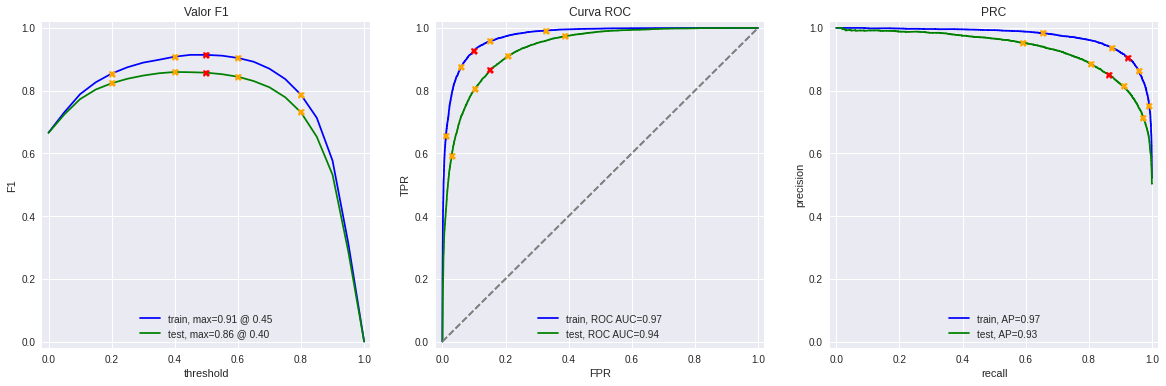

In [42]:
evaluate_model(model_lgbm, features_train_spacy, train_target, features_test_spacy, test_target)

###  Modelo 9 - BERT

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
    
    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    
    for input_text in texts:
        ids = tokenizer.encode(
            input_text,
            add_special_tokens = True,
            truncation = True,
            max_length = max_length
        ) # creación de los ids
        padded = np.array(ids + [0]*(max_length - len(ids))) #Relleno del vector con 0
        attention_mask = np.where(padded != 0, 1,0) # creación de mascara
        
        ids_list.append(padded) # Lista de ids
        attention_mask_list.append(attention_mask)
        
        
      
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch
        
        # unión de vectores de ids (de tokens) a un tensor
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # unión de vectores de máscaras de atención a un tensor
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)])
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'][:200], force_device='cuda')

#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

model_9= LogisticRegression()

model_9.fit(train_features_9, train_target[:200])

evaluate_model(model_9, train_features_9, train_target[:200], test_features_9, test_target[:200])

Analizando cada uno de los modelo podemos apreciar que el modelo con mejores resultados con respecto a la métrica F1, fueron los modelos de regresión lógica, este modelo se probó con lematización tanto con NLTK y con spaCy, en odnde podemos observar que el resultado no varía mucho y los valores son semejantes.

[Regresar a contenido](#back)

## 7. Mis reseñas <a id="reviews"></a>

In [43]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

pos= [0,0,1,0,1,1,1,1]

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


In [44]:
texts = my_reviews['review_norm']

my_reviews['nlkt_lemma']=texts.apply(lemma_nltk)

my_reviews['spacy_lemma']= texts.apply(lemma_spacy)

my_reviews[['nlkt_lemma','spacy_lemma']]

,nlkt_lemma,spacy_lemma
0,i did not simply like it not my kind of movie,I do not simply like it not my kind of movie
1,well i wa bored and felt asleep in the middle ...,well I be bored and feel asleep in the middle ...
2,i wa really fascinated with the movie,I be really fascinated with the movie
3,even the actor looked really old and disintere...,even the actor look really old and disinterest...
4,i did n't expect the reboot to be so good writ...,I do not expect the reboot to be so good write...
5,the movie had it upside and downside but i fee...,the movie have its upside and downside but I f...
6,what a rotten attempt at a comedy not a single...,what a rotten attempt at a comedy not a single...
7,launching on netflix wa a brave move i really ...,launch on netflix be a brave move I really app...


### Modelo 1

In [45]:


my_reviews_tf_idf_nltk = count_tf_idf_ntlk.transform(my_reviews['nlkt_lemma'])

my_reviews_pred_prob = model_1.predict_proba(my_reviews_tf_idf_nltk)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.46:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.30:  i didn't expect the reboot to be so good writers really cared about the source material
0.53:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [46]:
my_reviews_tf_idf_spacy = count_tf_idf_spacy.transform(my_reviews['spacy_lemma'])

my_reviews_pred_prob_model_3 = model_3.predict_proba(my_reviews_tf_idf_spacy)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.46:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.30:  i didn't expect the reboot to be so good writers really cared about the source material
0.53:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 4

In [47]:

my_reviews_pred_prob_model_4 = model_4.predict_proba(my_reviews_tf_idf_spacy)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_model_4[i]:.2f}:  {review}')

0.61:  i did not simply like it not my kind of movie
0.28:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.41:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.58:  i didn't expect the reboot to be so good writers really cared about the source material
0.71:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.35:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.81:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 9

texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

[Regresar a contenido](#back)

## Conclusiones <a id="end"></a>

Inicialmente se analizó los datos porporcionados, en donde se pudo apreciar que la calidad de los datos era buena, se detectaron datos ausentes (`average_rating` y `votes`) y tambien tipos de datos erroneos, pero no se trabajo en ellos, ya que estos se encontraban en columnas que no representaban alguna relevancia para nuestro análisis de textos, detectando que para nuestro propósito el conjunto de datos iniciales estaba lo suficientemente limpio.

Se realizó un análisis de datos, en donde globalmente podemos observar que el lanzamiento de las películas tienen una tendencia de incremento en función del paso de los años, por lo tanto de igual manera se observa el incremento de reseñas. También se observo que en los datos hay un balance en el tipo de reseñas positivas y negativas, esto lo ppodemos apreciar también en l histograma.

se probaron inicialmente los modelos regresión lógica (NLTK y spaCy) y LGBM (spaCy) con vactorización TF-IDF, de igual manera se probó solamente en un aocasión se probó el modelo regresión lógica con BERT y no fue exitoso, pero se deja la esturctura que se cree podría tener la silución. comparando los resultados de los diferentes modelos probados, el que mejor resultados tuvo fue el modelo de regresión lógica tanto con lematización NTKL y spaCy, comprobando que para un aanálisis de datos clasificatorios el mejor modelo es regresión lógica.

[Regresar a contenido](#back)